In [9]:
import sys
sys.path.append('..')
import os
os.chdir("..")
import logging
logging.basicConfig(level=logging.INFO)
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.simulator.gate_error_model import GateErrorModel

from janusq.analysis.vectorization import RandomwalkModel

from janusq.data_objects.random_circuit import random_circuits
from janusq.data_objects.backend import FullyConnectedBackend

from janusq.simulator.noisy_simulator import NoisySimulator
import random

from janusq.tools.ray_func import map

# Noise Optimization Based on JanusQ-CT


**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

The accurate fidelity prediction enables JanusQ-CT to guide the noise optimization. In this notebook, we introduce two optimization strategies.

## Mapping

A typical compilation flow includes routing and scheduling. The routing pass transforms the circuit to satisfy the processor topology. Clearly, it inserts SWAP gates to change the qubit mapping, ensuring that all two-qubit gates can be implemented by the coupler of the processor. By precisely predicting the fidelity, QuCT can be integrated with existing compilers to find the routing solution with the best fidelity. 

For example, wecan use Janus-CT to guide the mapping of qiskit.

In [10]:
# build a simulator

n_qubits = 5
n_steps = 1
n_walks = 20
backend = FullyConnectedBackend(n_qubits)

circuits = random_circuits(backend, n_circuits=500, n_gate_list=[30, 50, 100], two_qubit_prob_list=[.4], reverse=True)
vec_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
vec_model.train(circuits, multi_process=False, remove_redundancy = False)

all_paths = vec_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = vec_model

simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

INFO:root:start random walk for 501 circuits
100%|██████████| 501/501 [00:05<00:00, 95.76it/s] 
INFO:root:count path
INFO:root:device size after random walk = 15
INFO:root:0's path table size = 41
INFO:root:1's path table size = 41
INFO:root:2's path table size = 41
INFO:root:3's path table size = 41
INFO:root:4's path table size = 41
INFO:root:(0, 1)'s path table size = 35
INFO:root:(2, 4)'s path table size = 35
INFO:root:(1, 2)'s path table size = 35
INFO:root:(0, 4)'s path table size = 35
INFO:root:(3, 4)'s path table size = 35
INFO:root:(0, 3)'s path table size = 35
INFO:root:(1, 4)'s path table size = 35
INFO:root:(2, 3)'s path table size = 35
INFO:root:(0, 2)'s path table size = 35
INFO:root:(1, 3)'s path table size = 35


In [11]:
# train a fidelity model
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=True)

fidelity_model = FidelityModel(vec_model)
fidelity_model.train((circuits, ground_truth_fidelities))

INFO:root:len(train dataset) = 400, len(validation dataset) = 101
400it [00:00, 620000.59it/s]
100%|██████████| 14/14 [00:00<00:00, 82.88it/s]
101it [00:00, 490306.37it/s]
100%|██████████| 4/4 [00:00<00:00, 16.31it/s]
INFO:root:epoch: 0, 	 epoch loss = 609.5430297851562, 	 validation loss = 3.923463821411133
INFO:root:epoch: 100, 	 epoch loss = 194.24539184570312, 	 validation loss = 1.5192797183990479
INFO:root:epoch: 200, 	 epoch loss = 177.24053955078125, 	 validation loss = 1.4067935943603516
INFO:root:epoch: 300, 	 epoch loss = 168.70681762695312, 	 validation loss = 1.357567310333252
INFO:root:epoch: 400, 	 epoch loss = 163.7848663330078, 	 validation loss = 1.3355404138565063
INFO:root:epoch: 500, 	 epoch loss = 160.2580108642578, 	 validation loss = 1.3190362453460693
INFO:root:epoch: 600, 	 epoch loss = 157.94680786132812, 	 validation loss = 1.3059499263763428
INFO:root:epoch: 700, 	 epoch loss = 155.94740295410156, 	 validation loss = 1.2966091632843018
INFO:root:epoch: 800,

In [12]:
# generate a set of benchmarking circuits

from janusq.data_objects.algorithms import get_algs
from janusq.optimizations.scheduling.scheduling_ct import Scheduler
from janusq.optimizations.mapping.mapping_ct import Mapper
algs = ['qft', 'hs', 'ising', 'qknn', 'qsvm', 'vqc', 'ghz', 'grover']
benchmarking_circuits = get_algs(n_qubits, backend, algs)

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01550 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.07176 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis set() to target basis {'u', 'delay', 'reset', 'barrier', 'snapshot', 'cx', 'measure'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 3.01194 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: OptimizeSwapBeforeMeasure - 0.37050 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.06580 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: SetLayo

INFO:qiskit.compiler.transpiler:Total Transpile Time - 92.98587 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01192 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00834 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.06795 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis set() to target basis {'u', 'delay', 'reset', 'barrier', 'snapshot', 'cx', 'measure'}.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation path search completed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation paths composed in 0.000s.
INFO:qiskit.transpiler.passes.basis.basis_translator:Basis translation instructions replaced in 0.000s.
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 2.21920 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: OptimizeSwapBeforeMeasure - 0.04172 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMe

We evaluate the mapping guided by JanusQ-CT model with the qiskit optimizer with level = 3.

In [13]:
from janusq.data_objects.backend import LinearBackend


mapper = Mapper(fidelity_model)
mapping_backend = LinearBackend(n_qubits)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = mapper.run(circuit, mapping_backend, return_candidates=False)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before mapping: ', baseline_fidelities[-1], 'after mapping: ', opt_fidelities[-1])

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00882 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00882 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.62966 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('u', 1), ('cx', 2), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'save_state', '

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01121 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00954 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.69141 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before mapping:  0.85443574302685 after mapping:  0.8350369740375874


INFO:qiskit.compiler.transpiler:Total Transpile Time - 25.80667 (ms)
INFO:qiskit.execute_function:Total Job Submission Time - 0.12183 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00954 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00668 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.30923 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities

before mapping:  0.5225737992873339 after mapping:  0.29556991594734916


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.55885 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before mapping:  0.7189267871592862 after mapping:  0.7206276955553309


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.68855 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before mapping:  0.5287562356716127 after mapping:  0.4630478765000632


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01383 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01097 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.77581 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before mapping:  0.6530357159253538 after mapping:  0.5860196487278577


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00834 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.60933 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before mapping:  0.8030290634114123 after mapping:  0.8459999762625271


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00978 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.29039 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before mapping:  0.013111794897821499 after mapping:  0.11090572020847685


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01073 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.39689 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before mapping:  0.7366941603103008 after mapping:  0.25628885674986307


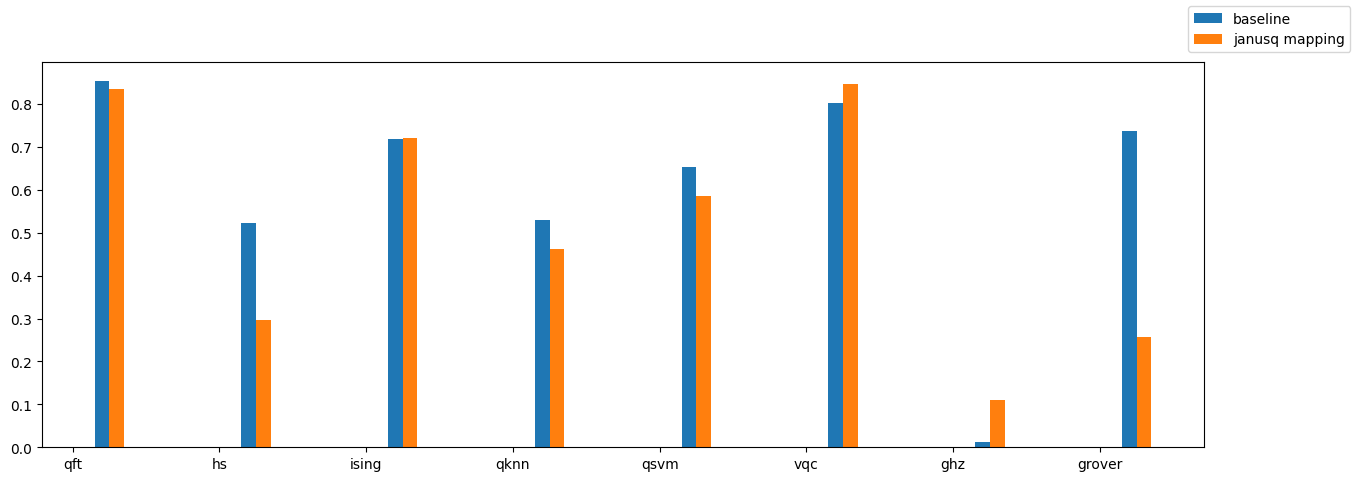

In [14]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))  
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,opt_fidelities,width =2,label='janusq mapping')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()

## Scheduling

We can also use Janus-CT to guide the scheduling.

In [15]:
scheduler = Scheduler(fidelity_model)
mapping_backend = LinearBackend(n_qubits)

baseline_fidelities, opt_fidelities = [], []
for circuit in benchmarking_circuits:
    baseline_fidelities.append(simulator.obtain_circuit_fidelity(circuit)[0])
    
    opt_circuit = scheduler.run(circuit, timeout=60)
    opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    
    opt_fidelities.append(opt_fidelity)
    print('before scheduling: ', baseline_fidelities[-1], 'after scheduling: ', opt_fidelities[-1])

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01335 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.06907 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('measure', 1), ('u', 1), ('cx', 2), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'save_state', '

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01001 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00930 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.82231 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before scheduling:  0.783069013874702 after scheduling:  0.7950143101004992


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.05937 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01049 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.34356 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before scheduling:  0.7466369639481792 after scheduling:  0.4185459359584195


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00787 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.47898 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before scheduling:  0.6399766037742985 after scheduling:  0.6008673520742125


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01287 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01240 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.76342 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before scheduling:  0.5456299941290383 after scheduling:  0.4650696176351457


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00811 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00834 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.55861 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before scheduling:  0.8289506184004566 after scheduling:  0.6993679347679927


INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01168 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00954 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 1.86014 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'sav

before scheduling:  0.7979108612771565 after scheduling:  0.7611292482102809


INFO:qiskit.passmanager.base_tasks:Pass: Depth - 0.08655 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00763 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Size - 0.03338 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: FixedPoint - 0.00620 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.00882 (ms)
INFO:qiskit.compiler.transpiler:Total Transpile Time - 24.81771 (ms)
INFO:qiskit.execute_function:Total Job Submission Time - 0.13995 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01025 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01001 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.27800 (ms)
INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set

before scheduling:  0.05524763371244186 after scheduling:  0.07330170658818297


INFO:qiskit.transpiler.passes.basis.basis_translator:Begin BasisTranslator from source basis {('u', 1), ('cx', 2), ('measure', 1), ('rx', 1), ('barrier', 5)} to target basis {'sx', 'pauli', 'set_statevector', 'save_amplitudes_sq', 'barrier', 't', 'p', 'mcsx', 'mcry', 'mcx_gray', 'z', 'mcrx', 'tdg', 'set_density_matrix', 'cswap', 'mcp', 'mcu', 'mcy', 'unitary', 'rx', 'kraus', 'save_expval_var', 'ccx', 'sdg', 'u3', 'delay', 'ryy', 'save_probabilities', 'save_amplitudes', 'save_stabilizer', 'mcu1', 'sxdg', 'mcrz', 'rxx', 'u1', 'mcz', 'mcswap', 'mcr', 'cu2', 'snapshot', 'multiplexer', 'cu1', 'save_density_matrix', 'save_probabilities_dict', 'initialize', 'diagonal', 'mcu2', 'r', 'quantum_channel', 'save_statevector_dict', 'mcu3', 'ry', 'rz', 'cu3', 'swap', 'reset', 'save_state', 's', 'save_expval', 'id', 'cx', 'u2', 'cp', 'cu', 'u', 'qerror_loc', 'roerror', 'save_statevector', 'mcphase', 'x', 'y', 'ecr', 'h', 'rzx', 'rzz', 'cz', 'set_stabilizer', 'mcx', 'cy', 'csx', 'measure'}.
INFO:qiskit

before scheduling:  0.7991898595714124 after scheduling:  0.7343741345926496


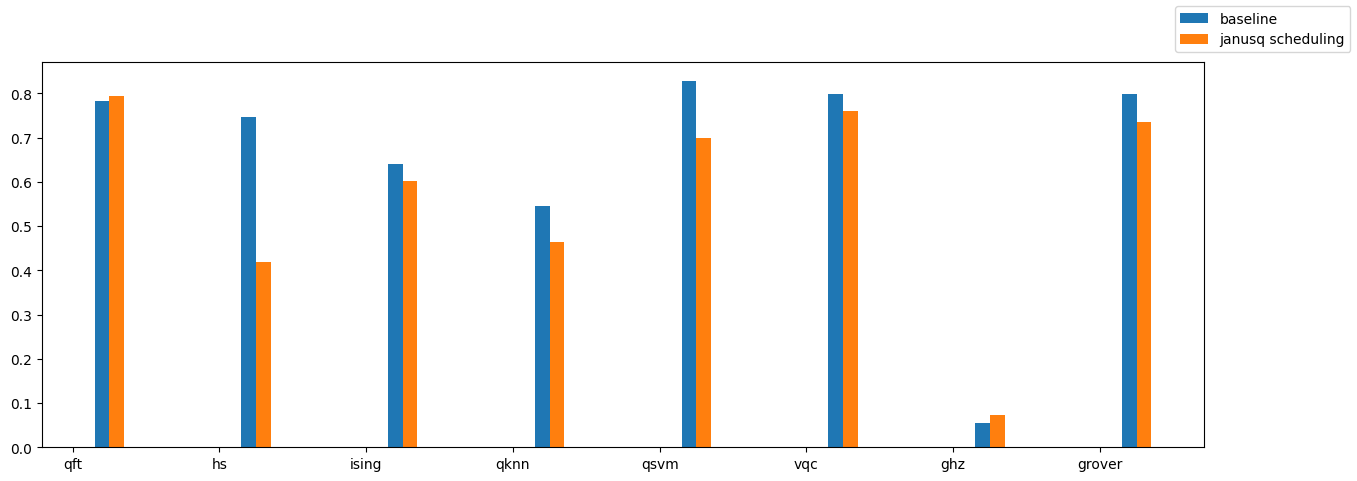

In [16]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 5))
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


baseline_fidelities = np.array(baseline_fidelities)
opt_fidelities = np.array(opt_fidelities)
axes.bar(x+4,baseline_fidelities,width =2,label='baseline')
axes.bar(x+6,opt_fidelities,width =2,label='janusq scheduling')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()